la dinamica della rete è descitta dall'equazione: tau*dx_i/dt=-x_i(t)+sum(J_ij*r_j(t))+sum(B_ik*u_k(t)) con r_j(t)=tanh(x_i(t))

In [2]:
import numpy as np
import random 
import matplotlib.pyplot as plt

Generation class trial

In [3]:
def trial(T=1000): #!!!!T=1000
        
    u=np.zeros((T,2))
    
    #y=np.zeros(T)
  
    stim1=np.random.randint(0,2) # random number, either 0 or 1 -> 0=A 1=B
    stim2=np.random.randint(0,2) # random number, either 0 or 1

    ty=2*stim1+stim2          #!!!! modified              #trial type: 0=AA, 1=BA, 2=AB, 3=BB

    ''' 
    if stim=0 (A) u1=1 and u2=0
    if stim=1 (B) u1=0 and u2=1
    '''
    
    u[:200,stim1]=1
    u[400:600,stim2]=1

    ''' 
    if identical inputs, output = -1
    if different inputs, output = 1
    '''
    
    #y[800:1000]=-1+2*np.mod(stim1+stim2,2)
    y=-1+2*np.mod(stim1+stim2,2)
    
    return u,y,ty


def generate_trials(n_trials,T=1000):

    U = np.zeros((n_trials,T,2))
    Y = np.zeros(n_trials)#,T))
    TY=np.zeros(n_trials)

    for n in range(n_trials):
        
        u,y,ty=trial(T)
        
        U[n,:,:]=u
        #Y[n,:]=y
        Y[n]=y
        TY[n]=ty

    return U,Y,TY
        

Constants and initialization

In [4]:
##### eta=0.1, alpha=0.5, rate=1., th=0.001


N=200           #numero neuroni
M=2             #numero input
tau=30          #tempo di rilassamento
g=1.5           #early chaotic
eta=0.1         #learning rate
alpha=0.5       #!!!! running average of response
beta = 0.05     #!!!! running average of x
rate=1./1000    #!!!


dt=1.
T=1000
n_trials=10000
tottime=T*n_trials

b=dt/tau            #per semplicità definisco una nuova costante


J=np.zeros((N,N))
deltaJ=np.zeros((N,N))  
x=np.zeros(N)       ##!!!
x_ave=np.zeros(N)   ##!!!
r=np.zeros(N)
u=np.zeros((M,tottime))

E=np.zeros((N,N))#,tottime)) 

z=np.zeros(tottime)
B=np.zeros((N,M))

U,Y,TY = generate_trials(T=T,n_trials=n_trials)

R_ave=np.zeros(4)       #running average for each trial type
err=np.zeros(n_trials)

u=np.reshape(U,(n_trials*T,2)).T


In [5]:
J = np.random.normal(0,g/np.sqrt(N),(N,N))

B= -1+2*np.random.rand(N,M)



Creating exploratory noise

Fix biased neurons

In [7]:
n_fixed=4

fixed_neurons = np.random.choice(N,n_fixed,replace=False)

non_fixed_neurons = np.delete(np.arange(N),fixed_neurons)

reading_neuron = np.random.choice(non_fixed_neurons,1)
reading_neuron = reading_neuron[0]


x[fixed_neurons]=1


Training

In [11]:
np.random.seed(2)

J = np.random.normal(0,g/np.sqrt(N),(N,N))

B= -1+2*np.random.rand(N,M)

x[:]=-0.1+0.2*np.random.rand(N) #!!!!
x[fixed_neurons]=1
E=np.zeros((N,N))#,tottime)) 
r[:]=0
R_ave=np.zeros(4)
outp=0
deltaE=np.zeros((N,N))
deltax=np.zeros(N)
rprev=np.zeros(N)

for ntime in range(tottime):
    
    if(np.mod(ntime,1*T)==0):
        print(ntime)
        print(R_ave)

    trialtime=np.mod(ntime,T)
       
    # !!!!
    '''
    timerunning=5
    
    if (trialtime<timerunning):
        short_term=np.arange(trialtime+1)
    else:
        short_term=np.arange(timerunning)       #indices from ntime-5 to ntime included 
    '''
    
    # "!!!
    
    if trialtime>=800 and trialtime<1000:
        outp+=r[reading_neuron] ###!!!!!
        
    #print(outp)
        
    r=np.tanh(x)
    
    #!!!!
    noise1=(np.random.rand(N)<rate)*(-0.5+1.*np.random.rand(N))
    
        
    sumJ=np.matmul(J,r)
        
    sumB=np.matmul(B,u[:,ntime])
    
    
    x[non_fixed_neurons]=x[non_fixed_neurons]/(1+b)+b/(1+b)*(sumJ[non_fixed_neurons]+\
                                                                           sumB[non_fixed_neurons])       #IMPLICITO

    x+=noise1 #noise[:,ntime]      #!!!         

    #!!!
    deltax=x-x_ave
    
    x_ave=beta*x_ave+(1.-beta)*x;  #!!!!

   
    rprev=r
    deltaE=np.outer(deltax,rprev) 
    deltaE=pow(deltaE,3)
    
    #deltaE=(np.outer(x[:,0]-x_ave[:],r[:,1]))**3     
    E+=deltaE

    #print(np.shape((r[:,1]*(x[:,0]-x_ave[:]).T)))
    
    
    
    if(np.mod(ntime,T)==T-1):                       #ultimo time step di ciascun trial 
        
        curr_trial=ntime//T
        curr_ty=int(TY[curr_trial])#trial type : 0=AA, 1=BA, 2=AB, 3=BB
        outp=outp/200
        #outp=np.mean(x[reading_neuron,(ntime-699):(ntime-499)]) #network output, mean over 200ms of response time

        err[curr_trial]=abs(Y[curr_trial]-outp)                             #network error = comparison between expected output and net output
        R=-err[curr_trial]
        
        print('type',curr_ty,err[curr_trial])
    
        deltaJ=-eta*(R-R_ave[curr_ty])*E*(-R_ave);

        ### !!!
        th=1.E-3
        deltaJ[deltaJ>th]=th
        deltaJ[deltaJ<-th]=-th

        J+=deltaJ

        R_ave[curr_ty]=alpha*R_ave[curr_ty]+(1-alpha)*R
        
        deltaJ=np.zeros((N,N)) 
        E=np.zeros((N,N))
        x[:]=-0.1+0.2*np.random.rand(N)
        x[fixed_neurons]=1
        r[:]=0
        outp=0



0
[0. 0. 0. 0.]
type 3 1.053778933166785
1000
[ 0.          0.          0.         -0.52688947]
type 1 1.4485332285378143
2000
[ 0.         -0.72426661  0.         -0.52688947]
type 2 0.4993178534954077
3000
[ 0.         -0.72426661 -0.24965893 -0.52688947]
type 2 0.4116896970029441
4000
[ 0.         -0.72426661 -0.33067431 -0.52688947]
type 3 1.0667205581611787
5000
[ 0.         -0.72426661 -0.33067431 -0.79680501]
type 0 1.5366733487124822
6000
[-0.76833667 -0.72426661 -0.33067431 -0.79680501]
type 1 1.2975596562313454
7000
[-0.76833667 -1.01091314 -0.33067431 -0.79680501]
type 3 1.0821106275182055
8000
[-0.76833667 -1.01091314 -0.33067431 -0.93945782]
type 1 1.2352219475595194
9000
[-0.76833667 -1.12306754 -0.33067431 -0.93945782]
type 2 0.5287483040785772
10000
[-0.76833667 -1.12306754 -0.42971131 -0.93945782]
type 3 1.031940278627842
11000
[-0.76833667 -1.12306754 -0.42971131 -0.98569905]
type 0 1.5376925080828854
12000
[-1.15301459 -1.12306754 -0.42971131 -0.98569905]
type 0 1.58

KeyboardInterrupt: 

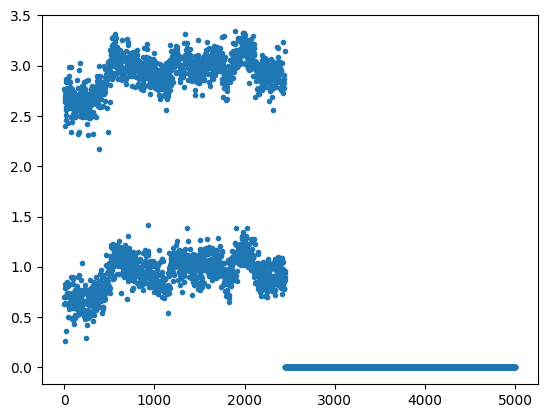

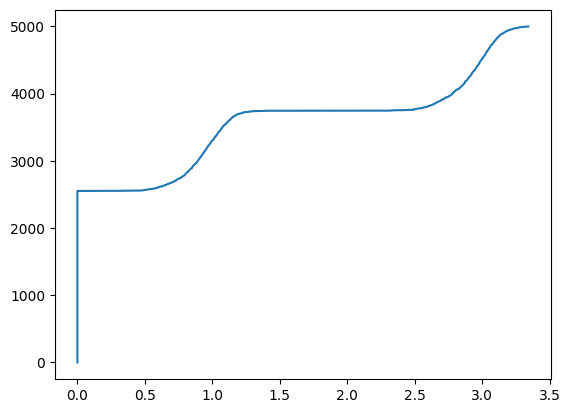

In [15]:
#err0=np.zeros(np.shape(err))
#err0[:]=err[:]

#plt.plot(err0,'.')
plt.plot(err,'.')
plt.show()

plt.figure
#plt.plot(np.sort(err0[:5000]),np.arange(len(err0)))
plt.plot(np.sort(err),np.arange(len(err)))

Simulation dynamics already trained